In [170]:
# main import
import sys
import os
import json
import nltk
import numpy as np
import pandas as pd

# analytics import
sys.path.append('..')
from preprocess import MediumBlogPost

# utils import
from utils import parse_date, get_word_count

# sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import RidgeCV, LassoCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_log_error

# visualization imports
import seaborn.apionly as sns
import matplotlib.pyplot as plt
%matplotlib inline


files = ['data-science.jl', 'startup.jl']

## load data

In [2]:
dfs = []
for file_name in files:
    file_path = os.path.join(os.environ['RAW_DATA_PATH'], file_name)
    with open(file_path) as f:
        for line in f:
            # get raw data
            row = MediumBlogPost(**json.loads(line)).to_frame()
            dfs.append(row)

df = pd.concat(dfs).reset_index(drop=True)

In [3]:
df.tail(2)

,title,publish_time,author,url,author_url,headings,contents,mins_read,claps,lang,tags
25019,13 Self-Destructive Habits of Unhappy and Unsu...,2018-08-24,Larry Kim,https://medium.com/marketing-and-entrepreneurs...,https://medium.com/@larrykim,13 Self-Destructive Habits of Unhappy and Unsu...,Stop sabotaging your own best efforts with neg...,6,208,en,"[Self Improvement, Startup, Marketing, Life Le..."
25020,"Slack just raised money at $ 7 B valuation, bu...",2018-08-24,ashu garg,https://medium.com/@ashugarg/slack-just-raised...,https://medium.com/@ashugarg,,Slack recently raised $ 427 M at a valuation o...,3,13,en,"[Slack, Startup, Microsoft, Google, Unicorns]"


## feature engineer

Base on previous EDA, we think the following features are sensible for predicting claps
1. year, month, day
2. title word count, stop word count, unusual word count
3. headings word count, stop word count, unusual word count
4. contents sentence count, contents word count, stop word count, unusual word count
5. number of buzz words in contents (optional / require n-gram tokens)
6. author number of blogs, average claps

NOTE:
1. feature eng items 1 to 5 are agnostic to future data
2. feature eng item 6 would potentially lead to data leakage if not handle properly, we should use hashing technique

### part i

In [14]:
# # 1. get date
# df_date = parse_date(df.publish_time)
# # 2. title wc
# df_title_wc = get_word_count(df.title)
# # 3. headings wc
# df_headings_wc = get_word_count(df.headings)
# # 4. contents wc
# df_contents_wc = get_word_count(df.contents)

In [3]:
# # save data
# df_features = pd.concat(
#     [
#         df_date,
#         df_title_wc,
#         df_headings_wc,
#         df_contents_wc,
#         df.author,
#         df.mins_read,
#     ],
#     axis=1
# )
# df_features.to_pickle('../data/features_V1.pkl')

In [135]:
df_features = pd.read_pickle('../data/features_V11.pkl')

## train / test split

In [151]:
X_train, X_test, y_train, y_test = train_test_split(
    df_features,
    df.claps,
    test_size=0.2,
    random_state=99)

print(X_train.shape, X_test.shape)

(20016, 17) (5005, 17)


In [137]:
X_train.head(2)

,year,month,day,title_word_count,title_stopword_count,title_unusual_word_count,title_total_word_count,headings_word_count,headings_stopword_count,headings_unusual_word_count,headings_total_word_count,contents_word_count,contents_stopword_count,contents_unusual_word_count,contents_total_word_count,author,mins_read
5729,2018,6,18,5,5,4,14,8,5,4,17,513,657,662,1832,Saral Karki,6
388,2018,1,15,8,2,2,12,8,2,2,12,660,853,526,2039,Maverick Lin,10


### part ii

In [152]:
# hash author to create author features
X_train['author'] = X_train['author'].apply(lambda name: hash(name) // 10 ** 9)


# add blogs count
blogs_cnt = pd.DataFrame(
    X_train['author'].groupby(X_train['author']).count()
).rename(columns={'author': 'blogs_cnt'})

# target encoding
claps_agg = pd.DataFrame(y_train.groupby(X_train['author']).agg(['mean', 'median', 'max', 'min']))
claps_agg = claps_agg.rename(columns={agg_name: 'author_{}'.format(agg_name) for agg_name in claps_agg.columns})

# merge on author
X_train = pd.DataFrame(
    pd.concat(
        [
            X_train.reset_index(drop=True), 
            blogs_cnt.reindex(X_train.author).reset_index(drop=True),
            claps_agg.reindex(X_train.author).reset_index(drop=True)
        ],
        axis=1
    ),
).drop('author', axis=1)

# hash author to create in test data
X_test['author'] = X_test['author'].apply(lambda name: hash(name) // 10 ** 9)
X_test = pd.DataFrame(
    pd.concat(
        [
            X_test.reset_index(drop=True), 
            blogs_cnt.loc[X_test.author].reset_index(drop=True),
            claps_agg.loc[X_test.author].reset_index(drop=True)
        ],
        axis=1
    ),
).drop('author', axis=1).fillna(0)

# X_train.head(2)

/Users/Kevin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/Kevin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Kevin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:32: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/in

In [47]:
blogs_cnt.describe()

,blogs_cnt
count,20016.000000
mean,4.327238
std,8.344232
min,1.000000
25%,1.000000
50%,2.000000
75%,4.000000
max,80.000000


In [46]:
claps_agg.describe()

,author_mean,author_median,author_max,author_min
count,20016.000000,20016.000000,20016.000000,20016.000000
mean,133.294864,111.278827,373.459782,70.290418
std,1042.736334,926.797538,3097.161407,778.728193
min,0.000000,0.000000,0.000000,0.000000
25%,0.500000,0.000000,1.000000,0.000000
50%,9.000000,5.000000,15.000000,1.000000
75%,61.000000,53.000000,99.000000,29.000000
max,67000.000000,67000.000000,103000.000000,67000.000000


## correlation signals

In [45]:
# correlation measure
data = pd.concat([X_train, np.log(y_train.reset_index(drop=True) + 1)], axis=1).corr()
pd.DataFrame(data['claps'].sort_values(ascending=False))

,claps
claps,1.000000
author_mean,0.285252
author_median,0.270796
author_max,0.261287
mins_read,0.249482
contents_stopword_count,0.233012
contents_total_word_count,0.225472
contents_word_count,0.218743
author_min,0.208376
contents_unusual_word_count,0.199458


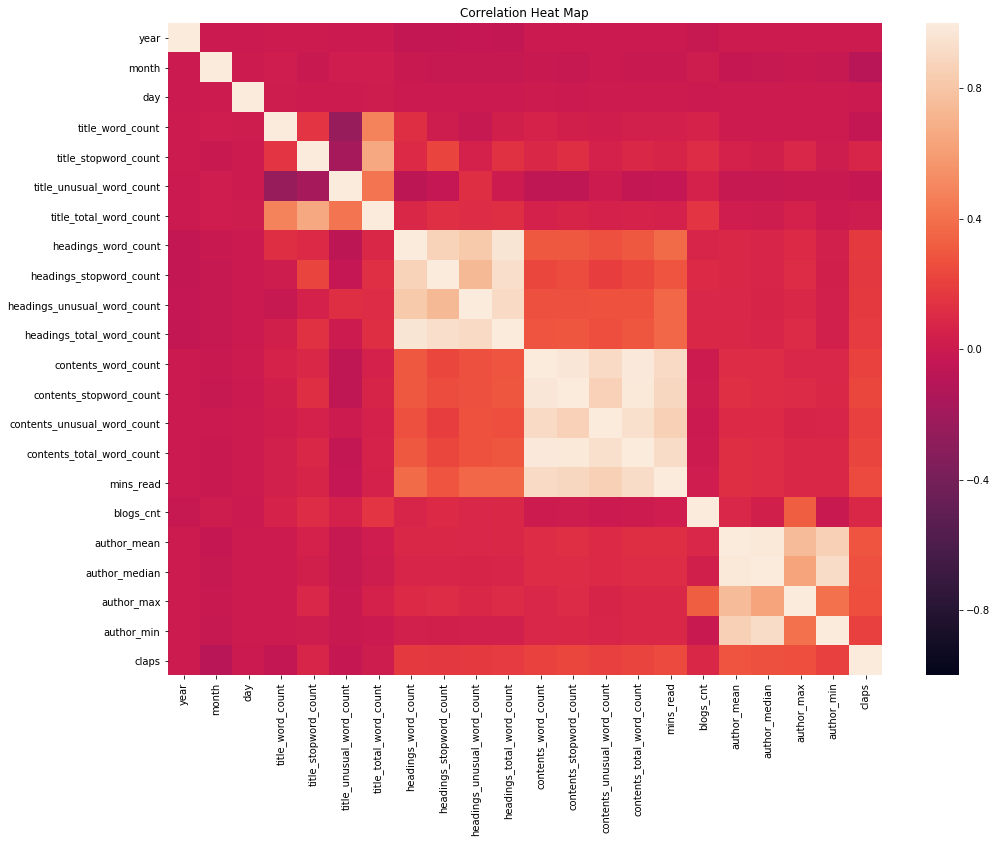

In [44]:
# heat map visual
fig, ax = plt.subplots(figsize=(16, 12))
ax.set_title('Correlation Heat Map')
sns.heatmap(data ,vmin=-1, vmax=1, ax=ax)

## Modeling Road Map
1. Ridge
2. Lasso (check weights to confirm intuition)
3. Random Forest

In [238]:
# 1. Ridge
ridge_pipe = Pipeline(
    [
        ('t0', StandardScaler()),
        ('e0', RidgeCV(
            alphas=[1.0, 2.0, 5.0, 10.0, 15.0, 20.0, 25.0, 30.0, 50.0],
            scoring='neg_mean_squared_error',
            cv=None,
            store_cv_values=True))
    ]
).fit(X_train, y_train)


# 2. Lasso
lasso_pipe = Pipeline(
    [
        ('t0', StandardScaler()),
        ('e0', LassoCV(
            n_alphas=100,
            cv=None,
            random_state=99))
    ]
).fit(X_train, y_train)


# 3. random forest
rf = RandomForestRegressor(
    n_estimators=100,
    max_depth=3,
    random_state=99
).fit(X_train, y_train)


## features analysis

In [239]:
pd.DataFrame(
    {
        'features': X_train.columns.values,
        'corr_w_claps': data['claps'].loc[X_train.columns].values.round(3),
        'ridge_weights': ridge_pipe.steps[-1][-1].coef_.round(3),
        'lasso_weights': lasso_pipe.steps[-1][-1].coef_.round(3),
        'rf_feature_importances': rf.feature_importances_.round(3)
    }
)

,features,corr_w_claps,ridge_weights,lasso_weights,rf_feature_importances
0,year,0.003,0.170,0.000,0.000
1,month,-0.089,-16.082,-0.000,0.011
2,day,-0.003,-2.648,-0.000,0.030
3,title_word_count,-0.039,0.723,-0.000,0.002
4,title_stopword_count,0.076,2.310,0.000,0.009
5,title_unusual_word_count,-0.026,-5.022,-0.000,0.021
6,title_total_word_count,0.015,-1.358,-0.000,0.019
7,headings_word_count,0.173,-19.237,0.000,0.009
8,headings_stopword_count,0.172,15.823,0.000,0.005
9,headings_unusual_word_count,0.173,7.245,0.000,0.029


## scoring

In [240]:
ridge_pipe.predict(X_test)

array([ 62.70879181,  12.25817088,  94.90290843, ..., -15.49144326,
        18.67039621,  -6.81341411])

In [251]:
# prediction
ridge_pred = ridge_pipe.predict(X_test)
lasso_pred = lasso_pipe.predict(X_test)
rf_pred = rf.predict(X_test)


# rmse score
ridge_mse = (mean_squared_error(y_test, ridge_pred)).round(2)
lasso_mse = (mean_squared_error(y_test, lasso_pred)).round(2)
rf_mse = (mean_squared_error(y_test, rf_pred)).round(2)

# rmse score
ridge_rmse = np.sqrt(mean_squared_error(y_test, ridge_pred)).round(2)
lasso_rmse = np.sqrt(mean_squared_error(y_test, lasso_pred)).round(2)
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_pred)).round(2)

In [253]:
pd.DataFrame(
    {
        'ridge': [ridge_rmse, ridge_mse],
        'lasso': [ridge_rmse, lasso_mse],
        'rf': [rf_rmse, rf_mse],
    },
    index=['rmse', 'mse']
)

,ridge,lasso,rf
rmse,663.75,663.75,732.88
mse,440567.25,423926.81,537112.01
